#### Introducing to the business problem

AB testing has different applications including optimizing the website or mobile app as well as determining the probability threshold for a second-time conversion rate for example. We can measure after building churn prediction what is the best probability threshold to encourage the user to another contact with the business. However, AB testing cannot tell you if you miss something. It compares old to new design / method / style. 

In this project due to data availability, I will concentrate on introducing a new feature on the website. You will exposure new and existing user to 2 different versions old version, called control group and the new method, called test group and will measure the response from the user. In the current version, we have a gate on level 30 and we want to test if this gate would be good to put on level 40 or keep in the old place - gate 30. 

In the dataset we have 5 columns such that: 

#### The dataset columns

| Column name | Description |
| --- | --- |
| user_id | A unique number that identifies each player |
| version | group 30 - control group group 40 & group 50 test group | 
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install |
| retention1 | Did the player come back and play 1 day after installing |
| retention_7 | Did the player come back and play 7 days after installing |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
games = pd.read_csv("C:/Users/fajlh/OneDrive/Documents/ABtest/AB_test_git/cookie_cats.csv")

In [3]:
games.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Important is to check if the number of users in control and each of the tests groups is similar. In AB testing it is a generally good approach to calculate the probability of the event. Click through probability - unique visitors who clicked / unique visitors to the page, probability of retention = number of users with retention in day 1 or 7 over the total number of users. This probability assures us that even if the sample size is different this probability is always between 0 and 1 and the binomial distribution of AB testing requires us to compare experiments using probability rather than the count. 

In [4]:
print("The total number of users taking part in the experiment either in the control or test group is {}".format(games.shape[0]))
print("The total number of users in the control group is {} and test group {}".format(games[games['version'] == 'gate_30'].shape[0], games[games['version'] == 'gate_40'].shape[0]))

The total number of users taking part in the experiment either in the control or test group is 90189
The total number of users in the control group is 44700 and test group 45489


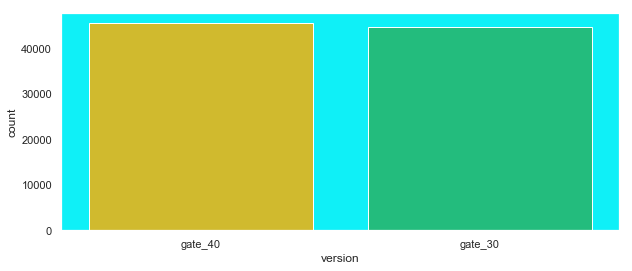

In [5]:
plt.figure(figsize=(10,4))
sns.set(rc={"axes.facecolor":"#0ff0f7", "axes.grid":False})
sns.countplot(x=games['version'] , order=games['version'].value_counts().index, palette=['#ebce13',"#09d681"])
plt.show()

Can we see any outlier that we can remove so that we can better understand the true difference? 

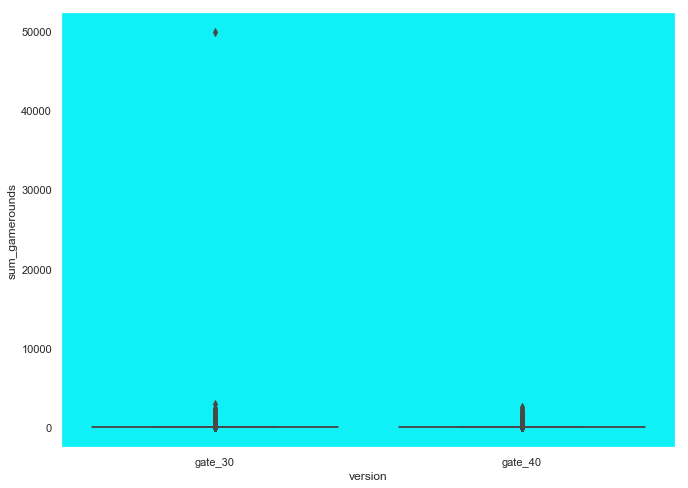

In [6]:
plt.figure(figsize=(11,8))
sns.boxplot(x=games.version ,palette="Set1", y = games.sum_gamerounds , color='black')
plt.show()

<Figure size 1440x792 with 0 Axes>

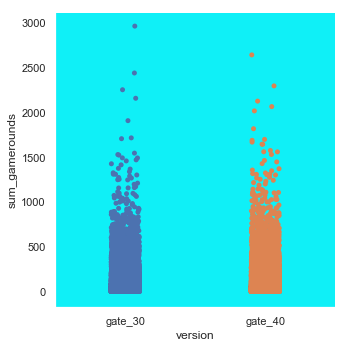

In [7]:
games = games[games['sum_gamerounds'] < 10000]

plt.figure(figsize=(20,11))
sns.catplot(x='version' , y='sum_gamerounds' , data=games)
plt.show()

In [8]:
games["retention_1"] = games["retention_1"].astype(int)
games["retention_7"] = games["retention_7"].astype(int)

#### Hypothesis testing

The word "hypothesis" is made of two words: hypo – under / less than and thesis – refer to place / generally held view. It is an effective way to use this fact when writing the hypothesis. I will refer to this way of writing the hypothesis:  

**Writing the “If” section of your Hypothesis**
 1. Start your sentence with the word “If”
 2. Write down one of the variables
 3. Connect statement with one of the following:
     * is related to
     * is affected by
     * causes
 4. Write down other variables
 
**Writing the “then” section of your Hypothesis**
 1. Comment on the relationship between those two variables.
 
**Hypothesis** - Main hypothesis of our interest. For example we can see that the increase of sum game rounds that player played potentially could decrease the retention date if we will take on account time that user needs to play for completing each round but is this change statistically significiant so to implement the change?   

*H0: If the retention rate is not affected by version of the game where the gate is placed on a different stage, then by placing the gate at level 40 we will not change the retention rate.*

*HA: If the retention rate is affected by the version of the game then placing the gate at level 40 will change the retention rate.* 

#### Statistics behind AB testing. 

The distribution of AB test can be seen as Binomial – success or failure of the experiment. Either retention rate increased or not, either number of games played increased or not. With sample mean µ = number of users with retention in day 1 / total number of users and SEmean =  $\sqrt{\frac{p(1-p)}{N}}$

We can use binomial distribution if there are 
* two outcomes success or failure, Ho or HA, 
* the events are independent 
* the events follow an identical distribution (probability of success needs to be identical for all of them) 

#### Probability of retention

First, we calculate statistics in the control group as that’s what we know. In our example, we can see that probability of retention day 1 in the control group is 0.448. 

In [9]:
p30_1 = games[(games['version'] == 'gate_30') & (games['retention_1'] == 1)].shape[0]/games[games['version'] == 'gate_30'].shape[0]
print("Probability of retention rate in the the control group is {:.2%}".format(p30_1))

Probability of retention rate in the the control group is 44.82%


#### Normality assumption

To use normality assumption for calculating a confidence interval for retention rate at control group I need to use the rule of thumb that if Np > 5 I can use normal distribution In our case is much more than that.

In [10]:
print("The normality assumption holds as N (number of observation in the control group) multiplied by p (probability of retention in the control group) is {}".format(int(games[games['version'] == 'gate_30'].shape[0] * (p30_1))))

The normality assumption holds as N (number of observation in the control group) multiplied by p (probability of retention in the control group) is 20034


#### Standard error of the mean and the margin of error

If you would repeat the experiment multiple of times the probability of retention would be different but it would start to form normal distribution, the bell curve.  Margin error is the width of the distribution around the mean and the standard error of the mean is the width from the mean of the means to the right or left side of the curve.

In [11]:
SE_30_1 = ((p30_1*(1-p30_1))/games[games['version'] == 'gate_30'].shape[0])**0.5
m30_1 = 1.96 * SE_30_1
print("The standard error of the mean for retention rate of the control group is {:.4f} with margin error of {:.4f} ".format(SE_30_1, m30_1))

The standard error of the mean for retention rate of the control group is 0.0024 with margin error of 0.0046 


#### Confidence interval for retention

95% confidence interval means that if we would theoretically repeat the experiment over and over again we would expect our interval around the sample mean to cover the true value of the population 95% of the time.  This means that if you run the experiment again with a similar number of players the number of retention in day 1 would be between 19,763 and 20,305 players.

In [12]:
print("The 99% Confidence Interval for the number of retention in day 1 for gate at level 30 would be between {:.0f} and {:.0f}".format((p30_1 - m30_1) * games[games['version'] == 'gate_30'].shape[0], (p30_1 + m30_1) * games[games['version'] == 'gate_30'].shape[0]))

The 99% Confidence Interval for the number of retention in day 1 for gate at level 30 would be between 19828 and 20240


We would need then to decide what change is important for us. What essential in addition to statistically significant confidence interval would be so to set the effective boundary to implement the change. You need to take in consideration other things before implementing the change such as business investment and time efficiency. 

Statistical significant is about repeatability. You want to get this guarantee that yes the measure is repeatable but also you want to be sure that if you see the difference between business standpoint so it’s practically significant it’s also statistically significant. To pick up practical significance let’s first pick up boundaries. Let say that from a business perspective 5% of change in the retention rate would be practically significant. Before running the experiment you need to decide how big the sample size you want it to be. How big the control and test group should be. 

To measure that let start from calculating 

#### Pooled probability and pooled standard error

We need to first calculate the pooled probability of the click. It is the total probability from the control and test group. 

In [13]:
pool = (games[(games['version'] == 'gate_30') & (games['retention_1'] == 1)].shape[0] + games[(games['version'] == 'gate_40') & (games['retention_1'] == 1)].shape[0]) / (games[games['version'] == 'gate_40'].shape[0] + games[games['version'] == 'gate_30'].shape[0])
SEpool = (pool * (1 - pool) * (1/games[games['version'] == 'gate_30'].shape[0] + 1/games[games['version'] == 'gate_40'].shape[0]))**0.5
print("The pooled probability in the experiment is {:.2%} with {:.4f} pooled standard error".format(pool, SEpool))

The pooled probability in the experiment is 44.52% with 0.0033 pooled standard error


In [14]:
p40_1 = games[(games['version'] == 'gate_40') & (games['retention_1'] == 1)].shape[0]/games[games['version'] == 'gate_40'].shape[0]
print("The retention rate in day 1 for the test group is {:.2%}".format(p40_1))

The retention rate in day 1 for the test group is 44.23%


If diff < -1.96 x SEpool or diff > 1.96 * SEpool then we can conculde that that the difference is due to change not due to chance. If the difference that we see is significiant or not. 

In [15]:
# estimated difference with the difference that we care about is to be 2%
diff = p40_1 - p30_1
m = -1.96*SEpool
print("The estimated difference in 1 day retention probability between test and control group is {:.4f} with {:.4f} margin of error".format(diff, m))

The estimated difference in 1 day retention probability between test and control group is -0.0059 with -0.0065 margin of error


In [16]:
# bounds of confidence interval 
print("The 95% confidence interval around the estimated difference is between {:.4f} and {:.4f}".format(diff - m, diff + m))
# This is highly proable that the change won't be bigger than 2% so we would not implement the change. 

The 95% confidence interval around the estimated difference is between 0.0006 and -0.0124


#### Type α and β errors

α = P(falsely conluding there is a difference) = P(reject null | null true). In our case we chose α to be 0.05 so 5%. 

If you would increase sample your standard error would decrease so the distribution around the mean would be narrower. Compare the pictures. Consider that there is a true difference between the mean. The difference is equal to a practical significant of 0.02 You fail to reject the null hypothesis and you conclude there is no statistically significant between two groups. 

In the small sample size β = P(fail to reject | null false) is pretty high (yellow shaded area). Then you would fail to reject the experiment that did have the difference you care about. Risk of a small sample is that alpha is low and beta is high. The yellow shaded region is the region of Beta and it depends on how big your effect was.

![Small sample size](sample1.png "Small sample size")

If you would increase sample your standard error would decrease so the distribution around the mean would be narrower.

![Larger sample size](sample2.png "Large sample size")

As your true change grows larger and larger then your beta would go down. You consider beta at your practical significant boundary as you don’t care about any smaller changes and any larger changes will have a lower beta that means a lower chance of error. With a larger sample, both distributions got tighter alpha doesn’t change but you are less more likely to reject the null and commit the beta error 

Important is too choose sample size large enought to have significance of the practical difference. There are many different online calculators that can help in determining sample size. 

![Sample size calculator](SampleSize.png "Sample Size calculator")

In [17]:
print("The sample size of the control group is {} and the sample size of the test group is {} so they are big enough to catch the significiance". format(games[games['version'] == 'gate_30'].shape[0], games[games['version'] == 'gate_40'].shape[0]))

The sample size of the control group is 44699 and the sample size of the test group is 45489 so they are big enough to catch the significiance


There are many things when considering the sample size:

* With increase of retention probability but still less than 50% you would need to increase the sample size. The standard error depends on the probability it’s proportional to  so I will need to increase the sample size to decrease the standard error 
* If you decide to increase your practical significance level  you can decrease the sample size. If you increase your practical significance level you look for larger change to detect. Larger changes are easier to detect so you won’t need so big sample size
* If you would consider increase your confidence level you would need to increase the sample size. You’re saying that you want to be more certain that the change occurred before you reject the null. If you want to keep your sensitivity the same you would need to increase the sample size. 

In our case, we would conclude that this is highly probable that the change won't be bigger than 2% so we would not implement the change.

![Reject or confirm the change](Sig.png "Reject or confirm the change")

This case is called neutral. You are confident that the result is not different than 0 since the confidence interval contains 0 and you are confident that there is no practically significant change. 

The business case significance is d = -0.2 or d = 0.2 The lower bound of confidence interval is -0.012 and the upper confidence interval is 0.0005. so it is eaxactly between the boundaries

#### 7 days retention change with change of the gate at level 40

Summarizing everything what we have learned above we can quickly calculation significiance of change to the 7 days retention rate. 

In [18]:
p30_7 = games[(games['version'] == 'gate_30') & (games['retention_7'] == 1)].shape[0]/games[games['version'] == 'gate_30'].shape[0]
SE_30_7 = ((p30_7*(1-p30_7))/games[games['version'] == 'gate_30'].shape[0])**0.5
m30_7 = 1.96*SE_30_7
print("The probability of 7 days retention in the control group is {:.2%} with standard error of {:.4f} and {:.4f} the margin of error".format(p30_7, SE_30_7, m30_7))

The probability of 7 days retention in the control group is 19.02% with standard error of 0.0019 and 0.0036 the margin of error


In [19]:
print("The 99% Confidence Interval for the number of retention in day 7 for gate at level 30 would be between {:.0f} and {:.0f}".format((p30_7 - m30_7) * games[games['version'] == 'gate_30'].shape[0], (p30_7 + m30_7) * games[games['version'] == 'gate_30'].shape[0]))

The 99% Confidence Interval for the number of retention in day 7 for gate at level 30 would be between 8338 and 8664


In [20]:
pool_7 = (games[(games['version'] == 'gate_30') & (games['retention_7'] == 1)].shape[0] + games[(games['version'] == 'gate_40') & (games['retention_7'] == 1)].shape[0]) / (games[games['version'] == 'gate_40'].shape[0] + games[games['version'] == 'gate_30'].shape[0])
SEpool_7 = (pool_7 * (1 - pool_7) * (1/games[games['version'] == 'gate_30'].shape[0] + 1/games[games['version'] == 'gate_40'].shape[0]))**0.5
print("The pooled probability of 7 days retention in the experiment is {:.2%} with {:.4f} standard error of the mean".format(pool_7, SEpool_7))

The pooled probability of 7 days retention in the experiment is 18.61% with 0.0026 standard error of the mean


In [21]:
p40_7 = games[(games['version'] == 'gate_40') & (games['retention_7'] == 1)].shape[0]/games[games['version'] == 'gate_40'].shape[0]
diff_7 = p40_7 - p30_7
m40_7 = -1.96*SEpool_7
print("The 7 days retention for the test group is {:.2%}. So the estimated difference of the mean between test and control group is {:.4f} with {:.4f} margin of error".format(p40_7, diff_7, m40_7))

The 7 days retention for the test group is 18.20%. So the estimated difference of the mean between test and control group is -0.0082 with -0.0051 margin of error


In [22]:
print("The 95% Confidence Interval for the number of retention in day 7 for gate at level 30 would be between {:.0f} and {:.0f}".format((p40_7 - m40_7) * games[games['version'] == 'gate_40'].shape[0], (p40_7 + m40_7) * games[games['version'] == 'gate_40'].shape[0]))
print("The 95% confidence interval around the estimated difference is between {:.4f} and {:.4f}".format(diff_7 - m40_7, diff_7 + m40_7))

The 95% Confidence Interval for the number of retention in day 7 for gate at level 30 would be between 8510 and 8048
The 95% confidence interval around the estimated difference is between -0.0031 and -0.0133


So again since the full confidence interval lies in the acceptance area we can accept the H0 and conculde that there is no statistically significiant difference between the control and test group so the change should be rejected. 